# Market Research -- User Rating Behaviors
Group member: Gretch Zhang, Baihe Yuan, Jacqueline Zhou, Disheng Wen, Siyuan Chen

### Description:
This research predicts users' rating behaviors based on their browsing history. The process involves Principle Components Analysis, K-means and linear regression.


## 1) Import Data

Import Packages and load data

In [ ]:
# useful packages
import numpy as np
import csv
import math
import pandas as pd
from sklearn import preprocessing
from sklearn import datasets
from sklearn import cluster
import matplotlib.pyplot as plt
import itertools
from sklearn.decomposition import PCA
import plotly.graph_objects as pgo

In [ ]:
# load data as a dataframe with pandas
user_history = pd.read_csv("user_history.csv")
user_history_without_user_ID = user_history.drop(['USER ID'],axis=1)
user_ratings = pd.read_csv("user_ratings.csv")

In [ ]:
# encode users as indices
le_user = preprocessing.LabelEncoder()
le_user.fit(user_history['USER ID'])

user_with_rating_index = le_user.transform(user_ratings['USER ID'])
all_user_index = le_user.transform(user_history['USER ID'])
user_ratings['USER INDEX'] = user_with_rating_index
user_ratings.head()

# encode products as indices
le_product = preprocessing.LabelEncoder()
le_product.fit(user_ratings['PRODUCT'])

product_ID = le_product.transform(user_ratings['PRODUCT'])
user_ratings['PRODUCT ID'] = product_ID
user_ratings.head()

,USER ID,PRODUCT,RATING,USER INDEX,PRODUCT ID
0,100950,secret postage,4,0,54
1,100950,violet saga,4,0,70
2,100950,pepper chicago,3,0,41
3,100950,nina sailor,2,0,35
4,100950,front salami,3,0,18


We can take the data in user_history and turn it into a matrix using the following command:

In [ ]:
history_M = user_history.to_numpy()
# leave out user ID column
his_M = history_M[:,1:]

For an introduction and short tutorial on pandas, you are invited to read over https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html.

## 2) Principal Component Analysis on User History data

The goal for this section is to divide the data into clusters and find the principal features to be used in the next section, linear regression, to predict the users' ratings based on their history data.

Now standardize the user history data and compute the SVD:

In [ ]:
# subtract the mean
his_meanzero = his_M - np.mean(his_M, axis=1, keepdims=True)
# divide by the standard deviation
his_std = his_meanzero/np.std(his_meanzero, axis=1, keepdims=True)
# SVD
U, S, VT = np.linalg.svd(his_std, full_matrices=False)

# make a figure showing the singular values
svd_figure = pgo.Figure([pgo.Bar(x=np.arange(len(S)), y=S)])
svd_figure.show()

We conclude that we will use the first three eigenvectors of the standardized data matrix.

Now compute the eigenvectors of history data's covariance matrix:

In [ ]:
# eigenvector contained in v
his_cov = np.cov(his_std.T)
w, v = np.linalg.eig(his_cov)

Try different combinations of the first tree eigenvectors as the feature matrix.

We produce the result of the PCA in this formula:
$Data = Feature^{T} * StdMatrix^{T}$

Then, we plot the transpose of the results in scatter to observe any possible patterns.

In [ ]:
# state the eigenvector to be used
v1 = (v[:,0]).real
v1 = v1.reshape((v1.shape[0], 1))
v2 = (v[:,1]).real
v2 = v2.reshape((v2.shape[0], 1))
v3 = (v[:,2]).real
v3 = v3.reshape((v3.shape[0], 1))

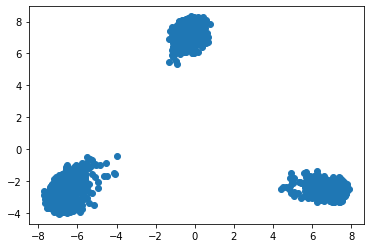

In [ ]:
# v1 and v2
f_12 = np.concatenate((v1, v2), axis = 1)
his_12 = (his_std @ f_12).T
plt.scatter(his_12[0],his_12[1])

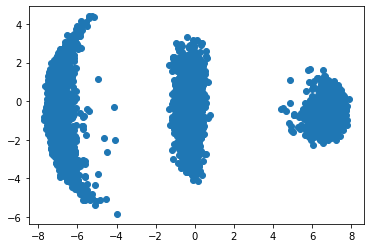

In [ ]:
# v1 and v3
f_13 = np.concatenate((v1, v3), axis = 1)
his_13 = (his_std @ f_13).T
plt.scatter(his_13[0],his_13[1])

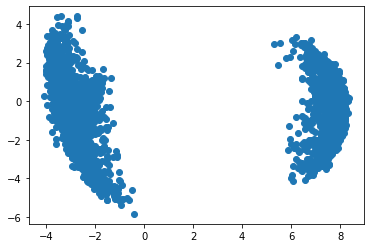

In [ ]:
# v2 and v3
f_23 = np.concatenate((v2, v3), axis = 1)
his_23 = (his_std @ f_23).T
plt.scatter(his_23[0],his_23[1])

When using the first two eigenvalues to project the history data, it did give the best classification result, thus we decide to use the first two eigen values **v1** and **v2**.

As shown in the first graph, we will classify the data into 3 clusters in the next K-means step.

## 2) K-means clustering

Now we use k-means method to cluster the data into 3 parts.

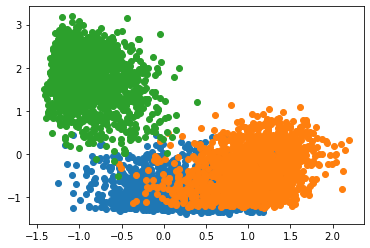

In [125]:
from sklearn.cluster import KMeans

chis_12 = KMeans(n_clusters=3)
his12=np.array(his_std)
#his12=np.transpose(his12)
chis_12.fit(his12)

plt.figure()
for i in range(3):
    plt.plot(his12[chis_12.labels_==i, 0], his12[chis_12.labels_==i, 1], 'o')


1. Standardize the first cluster

In [132]:
c1=his12[chis_12.labels_==0]
print(c1.shape)

(1500, 100)


In [133]:
# subtract the mean
c1_meanzero = c1 - np.mean(c1, axis=1, keepdims=True)
# divide by the standard deviation
c1_std = c1_meanzero/np.std(c1_meanzero, axis=1, keepdims=True)
# SVD
U, S, VT = np.linalg.svd(c1_std, full_matrices=False)

# make a figure showing the singular values
svd_figure = pgo.Figure([pgo.Bar(x=np.arange(len(S)), y=S)])
svd_figure.show()

Compute the eigenvector of the first cluster's covariance matrix

In [134]:
# eigenvector contained in v
c1_cov = np.cov(c1_std.T)
w, v1 = np.linalg.eig(c1_cov)
v1_1=v1[:,0].reshape((v1[:,0].shape[0],1))
c1_1 = c1_std @ v1_1
print(c1_1)

[[ 1.80500661]
 [ 0.17958245]
 [-3.36128174]
 ...
 [-2.72340842]
 [ 1.92337185]
 [ 0.47450529]]


2. Standardize the 2nd cluster

In [31]:
c2=his12[chis_12.labels_==2]
print(c2.shape)

(1500, 100)


In [32]:
c2=his12[chis_12.labels_==2]
# subtract the mean
c2_meanzero = c2 - np.mean(c2, axis=1, keepdims=True)
# divide by the standard deviation
c2_std = c2_meanzero/np.std(c2_meanzero, axis=1, keepdims=True)
# SVD
U, S, VT = np.linalg.svd(c2_std, full_matrices=False)

# make a figure showing the singular values
svd_figure = pgo.Figure([pgo.Bar(x=np.arange(len(S)), y=S)])
svd_figure.show()

Compute the eigenvector of the second cluster's covariance matrix

In [42]:
c2_cov = np.cov(c2_std.T)
w, v2 = np.linalg.eig(c2_cov)
v2_1 = v2[:,0].reshape((v2[:,0].shape[0],1))
c2_1 = c2_std @ v2_1
print(c2_1)

[[-2.59702368]
 [ 1.12922744]
 [-3.71578498]
 ...
 [ 4.02015613]
 [ 2.30323083]
 [-1.08702307]]


3. Standardize the 3rd cluster

In [131]:
c3=his12[chis_12.labels_==3]
# subtract the mean
c3_meanzero = c3 - np.mean(c3, axis=1, keepdims=True)
# divide by the standard deviation
c3_std = c3_meanzero/np.std(c3_meanzero, axis=1, keepdims=True)
# SVD
U, S, VT = np.linalg.svd(c3_std, full_matrices=False)

# make a figure showing the singular values
svd_figure = pgo.Figure([pgo.Bar(x=np.arange(len(S)), y=S)])
svd_figure.show()
print(c3)

[]


Compute the eigenvector of the 3rd cluster's covariance matrix

In [128]:
c3_cov = np.cov(c3_std.T)
w, v3 = np.linalg.eig(c3_cov)
v3_1 = v3[:,0].reshape((v3[:,0].shape[0],1))
c3_1 = c3_std @ v3_1
print(c3_1)

/var/folders/zj/4ndklncd13ndcy602vh9ltxr0000gn/T/ipykernel_51570/3199922118.py:1: RuntimeWarning:

Degrees of freedom <= 0 for slice



LinAlgError: Array must not contain infs or NaNs